<a href="https://colab.research.google.com/github/aswinigh/Cloth-simulation/blob/master/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
df_x = pd.read_csv('/content/drive/My Drive/MLProjectDataset/simulation_data_x.csv')
df_x.head()

,Vertex,x,y,z
0,0,1.030000,3.153230,4.998084
1,1,2.845850,2.773182,4.272925
2,2,0.746590,4.876459,4.299323
3,3,3.459904,5.463671,3.868554
4,4,0.677194,4.804018,4.484578


In [2]:
len(df_x)

384000

In [0]:
df_y = pd.read_csv('/content/drive/My Drive/MLProjectDataset/simulation_data_y.csv')

In [4]:
len(df_y)

47

In [0]:
no_scenes = len(df_y)

In [0]:
def prepare_data(dataset,no_scenes,vertices,no_frames):
  scene = []
  for j in range(no_scenes):
    frame = []
    for i in range(no_frames):
      frame.append(dataset[j*vertices*no_frames+i*vertices:j*vertices*no_frames+i*vertices+vertices])
    scene.append(frame)
  frame = scene
  for i in range(no_scenes):
    for t in range(20):
      frame[i][t] = frame[i][t].drop('Vertex ',axis=1)
      frame[i][t] = frame[i][t].values.flatten()
  return frame

In [0]:
scenes = prepare_data(df_x,no_scenes=no_scenes,vertices=400,no_frames=20)

In [12]:
len(scenes[0][0])

1200

# Data Exploration
We plot the means and standard deviations changing with respect to frame count(time)

In [0]:
import matplotlib.pyplot as plt

In [0]:
means_x = [scene[0][i][' x '].astype(float).mean() for i in range(20)]
means_y = [scene[0][i][' y '].astype(float).mean() for i in range(20)]
means_z = [scene[0][i][' z '].astype(float).mean() for i in range(20)]

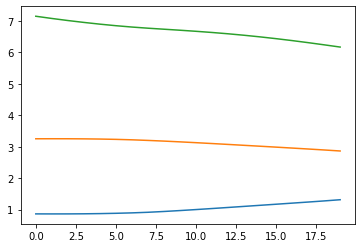

In [0]:
plt.plot([i for i in range(20)], means_x)
plt.plot([i for i in range(20)], means_y)
plt.plot([i for i in range(20)], means_z)
plt.show()

In [0]:
std_x = [scene[0][i][' x '].std() for i in range(20)]
std_y = [scene[0][i][' y '].std() for i in range(20)]
std_z = [scene[0][i][' z '].std() for i in range(20)]

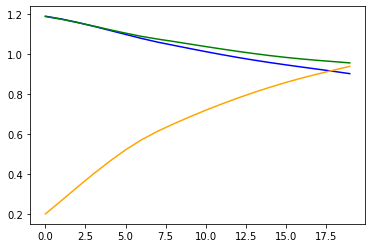

In [0]:
plt.plot([i for i in range(20)], std_x, color='blue')
plt.plot([i for i in range(20)], std_y, color='green')
plt.plot([i for i in range(20)], std_z, color='orange')
plt.show()

In [0]:
from mpl_toolkits.mplot3d import axes3d

def plot_frame(frame):
  z_x = [frame[j] for j in range(0,1200,3)]
  z_y = [frame[j] for j in range(1,1200,3)]
  z_z = [frame[j] for j in range(2,1200,3)]
  fig = plt.figure()
  fig.set_size_inches(18.5, 10.5)
  #ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
  ax = fig.gca(projection='3d')
  ax.set_zlim3d(-5,5)
  ax.set_xlim3d(-5,5)
  ax.set_ylim3d(-5,5)
  ax.scatter(z_x,z_y,z_z)

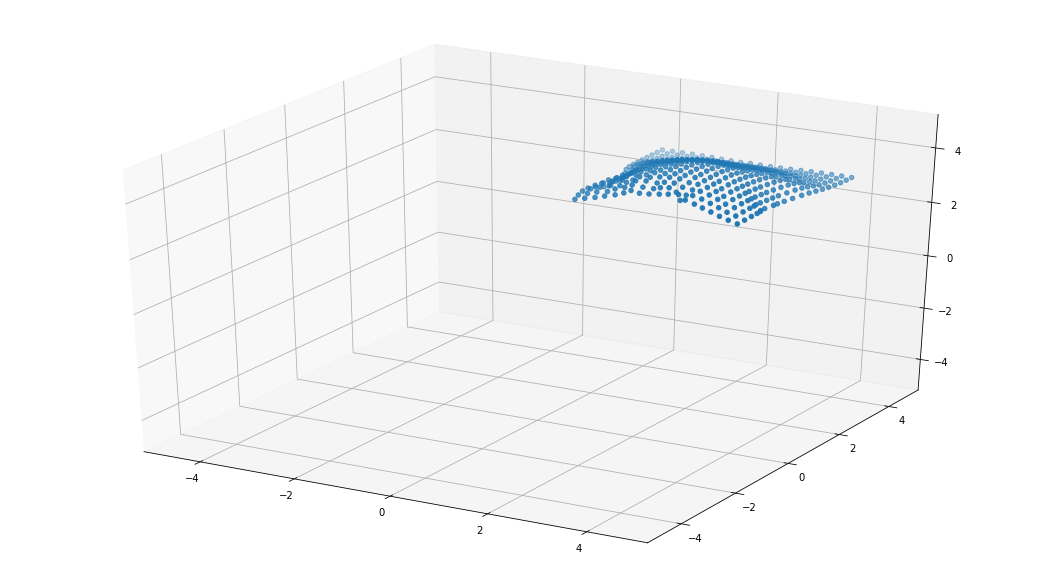

In [78]:
plot_frame(scenes[1][8])


# Data preperation

1.   We keep all the vertices for each frame in a single vector x(t) where t is the frame.
2.   We make a matrix X combining all the x(t) into a single matrix.



In [45]:
scenes[0][0].shape

(1200,)

In [0]:
allframes = []
for i in range(no_scenes):
  for t in range(20):
    allframes.append(frame[i][t])


In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=32)
principalComponents = pca.fit_transform(allframes)

In [49]:
pca.components_.shape

(32, 1200)

In [51]:
principalComponents[0]

array([ 2.51372624e+01, -3.30874774e+01, -1.73444551e+00, -6.34341648e+00,
       -3.57717064e+00,  8.82205403e+00, -3.36301965e+00, -8.33735066e-01,
        1.15374788e+00,  1.61220081e-01, -5.92636251e-01,  4.71102154e-01,
        5.55402764e-01,  1.02493586e+00,  3.94923578e-01,  1.09797802e+00,
       -2.05267299e-01,  6.70314606e-01, -3.30243674e-01, -1.89418568e-01,
        3.28649695e-01,  3.05848655e-01,  4.49531155e-02,  4.14561598e-02,
        2.16176260e-01, -2.99879027e-01,  3.19161742e-01,  6.14793650e-02,
        5.94239193e-01,  2.43521912e-02,  1.06294677e-01, -1.18317004e-01])

In [52]:
pca.inverse_transform(principalComponents[0])

array([1.03407184, 3.14917127, 4.96226485, ..., 3.41861917, 5.48485441,
       4.18596894])

In [53]:
allframes[0]

array([1.02999994, 3.15323038, 4.99808437, ..., 3.44081088, 5.44457502,
       4.16360838])

# Initial Model
We use linear regression to get the approximate motion of the cloth and to model inertia. 
This stage does not model the interaction with other objects.

In [0]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [0]:
xk = []
for k in range(32):
  x1 = []
  for j in range(no_scenes):
    for i in range(18):
      x1.append([principalComponents[j*20 + i+1][k],principalComponents[j*20 + i+1][k]-principalComponents[j*20+i][k]])
  xk.append(x1)

In [0]:
yk = []
for k in range(32):
  y1 = []
  for j in range(no_scenes):
    for i in range(2,20):
      y1.append(principalComponents[j*20+i][k])
  yk.append(y1)

In [0]:
for i in range(32):
  xk[i] = np.array(xk[i])
  yk[i] = np.array(yk[i])

In [0]:
regressors = []
for k in range(32):
  regressors.append(LinearRegression().fit(xk[k],yk[k]))

In [111]:
len(principalComponents)

940

In [0]:
def predict_regressors(frame1transformed,frame2transformed):
  p1 = frame1transformed
  p2 = frame2transformed
  predictions = []
  for k in range(len(regressors)):
    z_pred = [p1[k],p2[k]]
    for i in range(1,18):
      #print(z_pred)
      z_pred.append(regressors[k].predict([[z_pred[i],z_pred[i]-z_pred[i-1]]])[0])
    predictions.append(z_pred)
  return predictions

In [0]:
def inverse_transform_predictions(z):
  predictions = []
  for f in range(18):
    z_new = []
    for i in range(32):
      z_new.append(z[i][f])
    predictions.append(pca.inverse_transform(z_new))
  return predictions

In [0]:
z_pred = predict_regressors(principalComponents[40],principalComponents[41])

In [0]:
final_value = inverse_transform_predictions(z_pred)

In [114]:
final_value[17]

array([-1.67149919,  3.5835237 ,  2.81016359, ...,  1.58426991,
        6.80864862,  2.76926254])

In [116]:
scenes[2][19]

array([-0.46815973,  3.78808178,  3.83237096, ...,  1.1925287 ,
        5.79302491,  3.29351231])

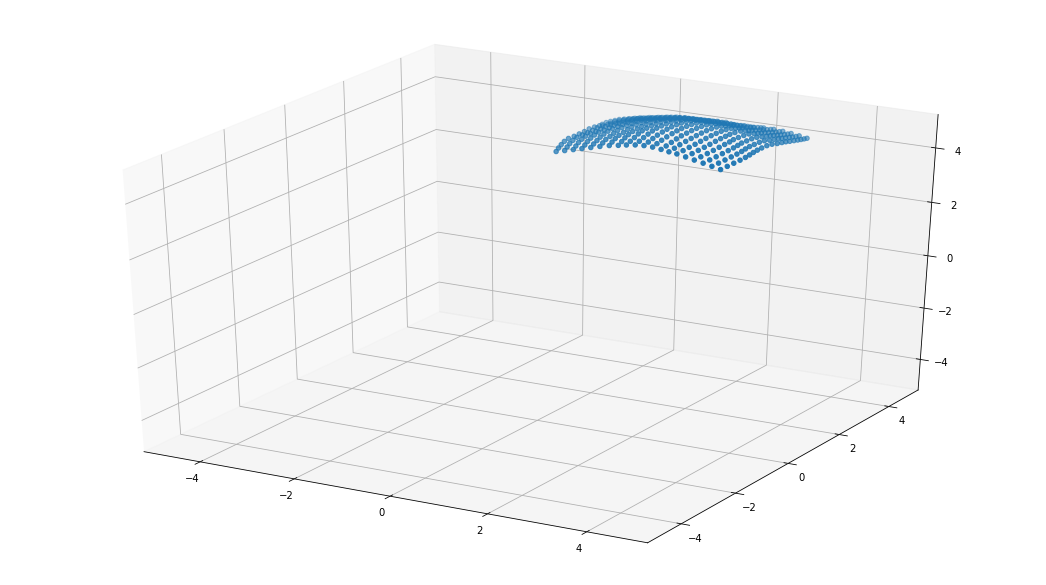

In [117]:
plot_frame(final_value[17])

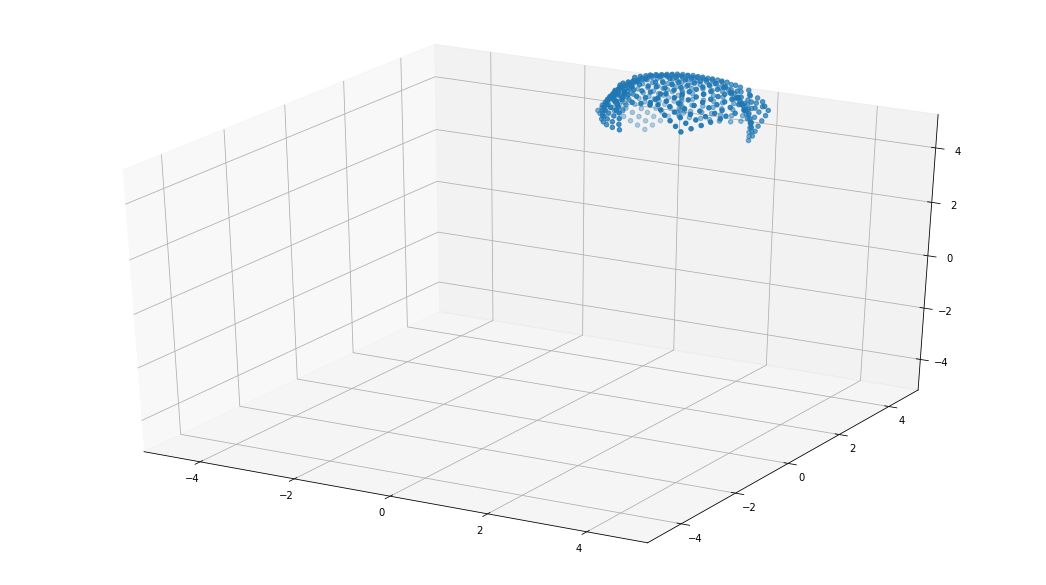

In [118]:
plot_frame(scenes[2][19])

# DNN correction 

In [0]:
x = scenes

In [0]:
y = np.array(df_y)

In [127]:
len(y)

47

In [0]:
for i in range(no_scenes):
  x[i] = pca.transform(x[i])

In [134]:
x[0].shape

(20, 32)

In [0]:
z_actual = x[0]